## Variability metrics for VHF timeseries 

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

### Time-integrated area under the curve (AUC)

Non-normalized

In [77]:
def auc_signed(series, max_gap):
    """
    calculates AUC, excluding intervals larger than max_gap.
    """
    s = series.dropna().sort_index()
    dt = s.index.to_series().diff()

    valid = dt <= max_gap
    dt_numeric = dt.dt.total_seconds() / 86400  # converts to days
    
    # filter both the values and time differences with the same mask
    s_prev = s.shift(1)
    auc = (s_prev[valid] * dt_numeric[valid]).sum() # exclude intervals larger than max_gap

    return auc

Normalized

In [78]:
def auc_signed_normalized(series, max_gap):
    """
    AUC normalized by total valid duration.
    """
    s = series.dropna().sort_index()
    dt = s.index.to_series().diff()

    valid = dt <= max_gap
    dt_numeric = dt.dt.total_seconds() / 86400  # converts to days
    
    # filter both the values and time differences with the same mask
    s_prev = s.shift(1)
    weighted_sum = (s_prev[valid] * dt_numeric[valid]).sum()
    total_time = dt_numeric[valid].sum()

    if total_time == 0:
        return np.nan

    return weighted_sum / total_time


### Fraction of time being positive vs negative

Only duration

In [79]:
def fraction_positive(series, max_gap):
    """
    fraction of valid time spent in positive conditions.
    """
    s = series.dropna().sort_index()
    dt = s.index.to_series().diff()

    valid = dt <= max_gap
    dt_numeric = dt.dt.total_seconds() / 86400  # converts to days
    
    pos_time = dt_numeric[valid & (s.shift(1) > 0)].sum()
    total_time = dt_numeric[valid].sum()

    if total_time == 0:
        return np.nan

    return pos_time / total_time


Weighted by magnitude

In [80]:
def fraction_positive_weighted(series, max_gap):
    """
    fraction of total absolute magnitude-time contributed by positive values.
    """
    s = series.dropna().sort_index()
    dt = s.index.to_series().diff()

    valid = dt <= max_gap
    dt_numeric = dt.dt.total_seconds() / 86400  # converts to days
    
    pos = (s.shift(1)[valid & (s.shift(1) > 0)] * dt_numeric[valid & (s.shift(1) > 0)]).sum()
    neg = (np.abs(s.shift(1)[valid & (s.shift(1) < 0)]) * dt_numeric[valid & (s.shift(1) < 0)]).sum()

    denom = pos + neg
    if denom == 0:
        return np.nan

    return pos / denom

### Number of times it crosses zero

Excluding data gaps

In [81]:
def zero_crossing_count_exc(series, max_gap):
    """
    number of sign changes, excluding large gaps.
    """
    s = series.dropna().sort_index()
    dt = s.index.to_series().diff()

    valid = dt <= max_gap
    signs = np.sign(s)

    crossings = (
        valid   
        & (signs.shift(1) * signs < 0)  # count sign changes only where valid
    )

    return crossings.sum()

Including data gaps

In [82]:
def zero_crossing_count_inc(series, max_gap):
    """
    number of sign changes, including data gaps.
    """
    s = series.dropna().sort_index()
    s = s[s != 0]  # remove exact zeros to avoid ambiguity in sign changes
    signs = np.sign(s.values)

    crossings = (signs[:-1] * signs[1:] < 0)  # count all sign changes
    return crossings.sum()

### Difference in percentiles

In [83]:
def calculate_percentile_range(data):
    """
    calculate the 10th and 90th percentiles of the VHF timeseries and their difference.
    """
    # remove NaN values
    valid_data = np.array(data)[~np.isnan(data)]
    # calculate percentiles
    p10 = np.percentile(valid_data, 5)
    p90 = np.percentile(valid_data, 95)
    # calculate difference
    difference = p90 - p10
    
    return p10, p90, difference

## Calculations

In [84]:
spring = pd.read_csv("../spring_HF.csv", parse_dates=["Date"], index_col="Date")
summer = pd.read_csv("../summer_HF.csv", parse_dates=["Date"], index_col="Date")
exceedance_hf = pd.read_csv("hf_during_exceedance_periods.csv", parse_dates=["Date"], index_col="Date")
probe_names = ["T1", "T2", "T3", "T5", "T6", "T7", "T8"]

# convert to m/day
for probe in  probe_names:
    spring[probe] = spring[probe] * 86400 
    summer[probe] = summer[probe] * 86400
    exceedance_hf[probe] = exceedance_hf[probe] * 86400

In [85]:
# get date ranges from spring and summer dataframes
spring_start = spring.index.min()
spring_end = spring.index.max()
summer_start = summer.index.min()
summer_end = summer.index.max()
# filter exceedance_hf by these date ranges
exceedance_spring = exceedance_hf[(exceedance_hf.index >= spring_start) & (exceedance_hf.index <= spring_end)]
exceedance_summer = exceedance_hf[(exceedance_hf.index >= summer_start) & (exceedance_hf.index <= summer_end)]

Spring 

In [86]:
# AUC 
auc_sp = {}
auc_sp_norm = {}
fract_pos_sp = {}
fract_pos_wt_sp = {}
zero_crossings_sp = {}
p10_sp = {}
p90_sp = {}
percentile_diff_sp = {}
for probe in ["T1", "T2", "T3", "T5", "T6", "T7", "T8"]:
    s = exceedance_spring[probe]
    # auc
    auc_sp[probe] = auc_signed(s, max_gap=pd.Timedelta("1min")) 
    # normalized AUC 
    auc_sp_norm[probe] = auc_signed_normalized(s, max_gap=pd.Timedelta("1min")) 
    # note: this is the exact same thing as the average HF during exceedance periods (sum HF * dt) / (total dt)
    # fraction positive time
    fract_pos_sp[probe] = fraction_positive(s, max_gap=pd.Timedelta("1min"))
    # fraction positive weighted
    fract_pos_wt_sp[probe] = fraction_positive_weighted(s, max_gap=pd.Timedelta("1min"))
    # zero crossing count including gaps
    zero_crossings_sp[probe] = zero_crossing_count_inc(s, max_gap=pd.Timedelta("1min"))
    # percentiles
    p10, p90, diff = calculate_percentile_range(s)
    p10_sp[probe] = p10
    p90_sp[probe] = p90
    percentile_diff_sp[probe] = diff

In [87]:
# combine all metrics into a single DataFrame
spring_metrics = pd.DataFrame({
    'AUC': auc_sp,
    'AUC_normalized': auc_sp_norm,
    'Fraction_positive_time': fract_pos_sp,
    'Fraction_positive_weighted': fract_pos_wt_sp,
    'Zero_crossings': zero_crossings_sp,
    '90th_percentile': p90_sp,
    '10th_percentile': p10_sp,
    'Percentile_difference': percentile_diff_sp
})
spring_metrics.to_csv("spring_exceedance_metrics.csv")
print(spring_metrics)

         AUC  AUC_normalized  Fraction_positive_time  \
T1  1.838833        0.205027                1.000000   
T2 -2.838513       -0.316489                0.000000   
T3 -0.986690       -0.110014                0.000000   
T5  0.541154        0.060338                1.000000   
T6 -0.311919       -0.034778                0.009524   
T7 -1.505322       -0.167841                0.000000   
T8 -0.299388       -0.033381                0.000000   

    Fraction_positive_weighted  Zero_crossings  90th_percentile  \
T1                    1.000000               0         0.280803   
T2                    0.000000               0        -0.243472   
T3                    0.000000               0        -0.021180   
T5                    1.000000               0         0.098496   
T6                    0.002844               2        -0.015361   
T7                    0.000000               0        -0.034312   
T8                    0.000000               0        -0.008441   

    10th_perce

Summer

In [88]:
# AUC 
auc_sm = {}
auc_sm_norm = {}
fract_pos_sm = {}
fract_pos_wt_sm = {}
zero_crossings_sm = {}
p10_sm = {}
p90_sm = {}
percentile_diff_sm = {}
for probe in ["T1", "T2", "T3", "T5", "T6", "T7", "T8"]:
    s = exceedance_summer[probe]
    # auc
    auc_sm[probe] = auc_signed(s, max_gap=pd.Timedelta("1min")) 
    # normalized AUC 
    auc_sm_norm[probe] = auc_signed_normalized(s, max_gap=pd.Timedelta("1min")) 
    # note: this is the exact same thing as the average HF during exceedance periods (sum HF * dt) / (total dt)
    # fraction positive time
    fract_pos_sm[probe] = fraction_positive(s, max_gap=pd.Timedelta("1min"))
    # fraction positive weighted
    fract_pos_wt_sm[probe] = fraction_positive_weighted(s, max_gap=pd.Timedelta("1min"))
    # zero crossing count including gaps
    zero_crossings_sm[probe] = zero_crossing_count_inc(s, max_gap=pd.Timedelta("1min"))
    # percentiles
    p10, p90, diff = calculate_percentile_range(s)
    p10_sm[probe] = p10
    p90_sm[probe] = p90
    percentile_diff_sm[probe] = diff

In [89]:
summer_metrics = pd.DataFrame({
    'AUC': auc_sm,
    'AUC_normalized': auc_sm_norm,
    'Fraction_positive_time': fract_pos_sm,
    'Fraction_positive_weighted': fract_pos_wt_sm,
    'Zero_crossings': zero_crossings_sm,
    '90th_percentile': p90_sm,
    '10th_percentile': p10_sm,
    'Percentile_difference': percentile_diff_sm
})
summer_metrics.to_csv("summer_exceedance_metrics.csv")
print(summer_metrics)

         AUC  AUC_normalized  Fraction_positive_time  \
T1 -0.727369       -0.255528                0.198341   
T2 -0.928618       -0.326228                0.000000   
T3 -0.852641       -0.299537                0.000000   
T5  0.254246        0.089318                1.000000   
T6 -0.164230       -0.057695                0.096853   
T7 -0.351640       -0.123533                0.000000   
T8 -0.148795       -0.052272                0.096853   

    Fraction_positive_weighted  Zero_crossings  90th_percentile  \
T1                    0.140224               1         0.294359   
T2                    0.000000               0        -0.248648   
T3                    0.000000               0        -0.246240   
T5                    1.000000               0         0.264568   
T6                    0.048581               2         0.031505   
T7                    0.000000               0        -0.039194   
T8                    0.020664               2         0.010719   

    10th_perce

### Plots

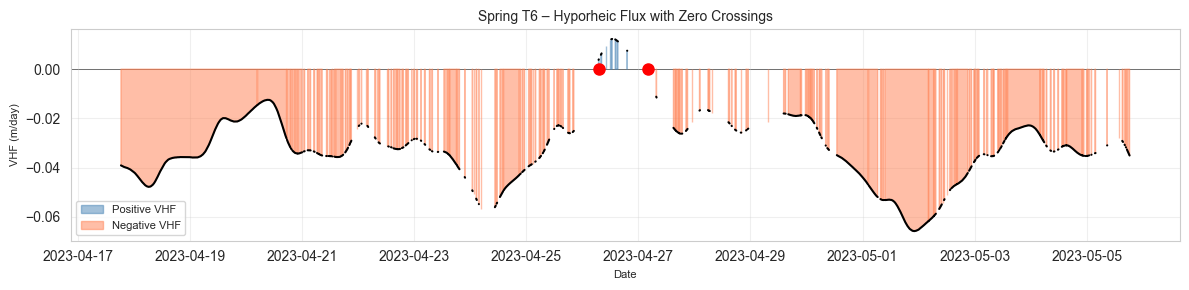

In [90]:
max_gap = pd.Timedelta("5min")  # define data gap
s = exceedance_spring["T6"].dropna().sort_index()
positive_color = 'steelblue'
negative_color = 'coral'

# insert NaNs at gaps to break line plotting
dt = s.index.to_series().diff()
s_plot = s.copy()
s_plot[dt > max_gap] = np.nan
# zero crossings (gap-bridged)
s_zc = s[s != 0]
signs = np.sign(s_zc.values)
crossings = signs[:-1] * signs[1:] < 0
crossing_indices = np.where(crossings)[0] + 1

# figure
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(s_plot.index, s_plot.values, 'k-', linewidth=1.5, label='VHF', zorder=2) # time series (no connections across gaps) 
# area filling (vectorized) 
ax.fill_between(s_plot.index, 0, s_plot.values, where=(s_plot.values > 0), interpolate=True, color=positive_color, alpha=0.5, zorder=1) # positive
ax.fill_between(s_plot.index, 0, s_plot.values, where=(s_plot.values < 0), interpolate=True, color=negative_color, alpha=0.5,zorder=1) # negative

# mark zero crossings
for idx in crossing_indices:
    if idx < len(s_zc):
        ax.plot( s_zc.index[idx], 0, 'o', color='red', markersize=8, zorder=3, label='Zero crossing' if idx == crossing_indices[0] else None)

ax.axhline(0, color='k', linewidth=0.5, zorder=0)
ax.set_xlabel('Date', fontsize=8)
ax.set_ylabel('VHF (m/day)', fontsize=8)
ax.set_title('Spring T6 – Hyporheic Flux with Zero Crossings', fontsize=10)
ax.grid(True, alpha=0.3)

positive_patch = mpatches.Patch(color=positive_color, alpha=0.5, label='Positive VHF')
negative_patch = mpatches.Patch(color=negative_color, alpha=0.5, label='Negative VHF')
ax.legend(handles=[positive_patch, negative_patch], loc='best', fontsize=8)

plt.tight_layout()
plt.show()


Big Subplot

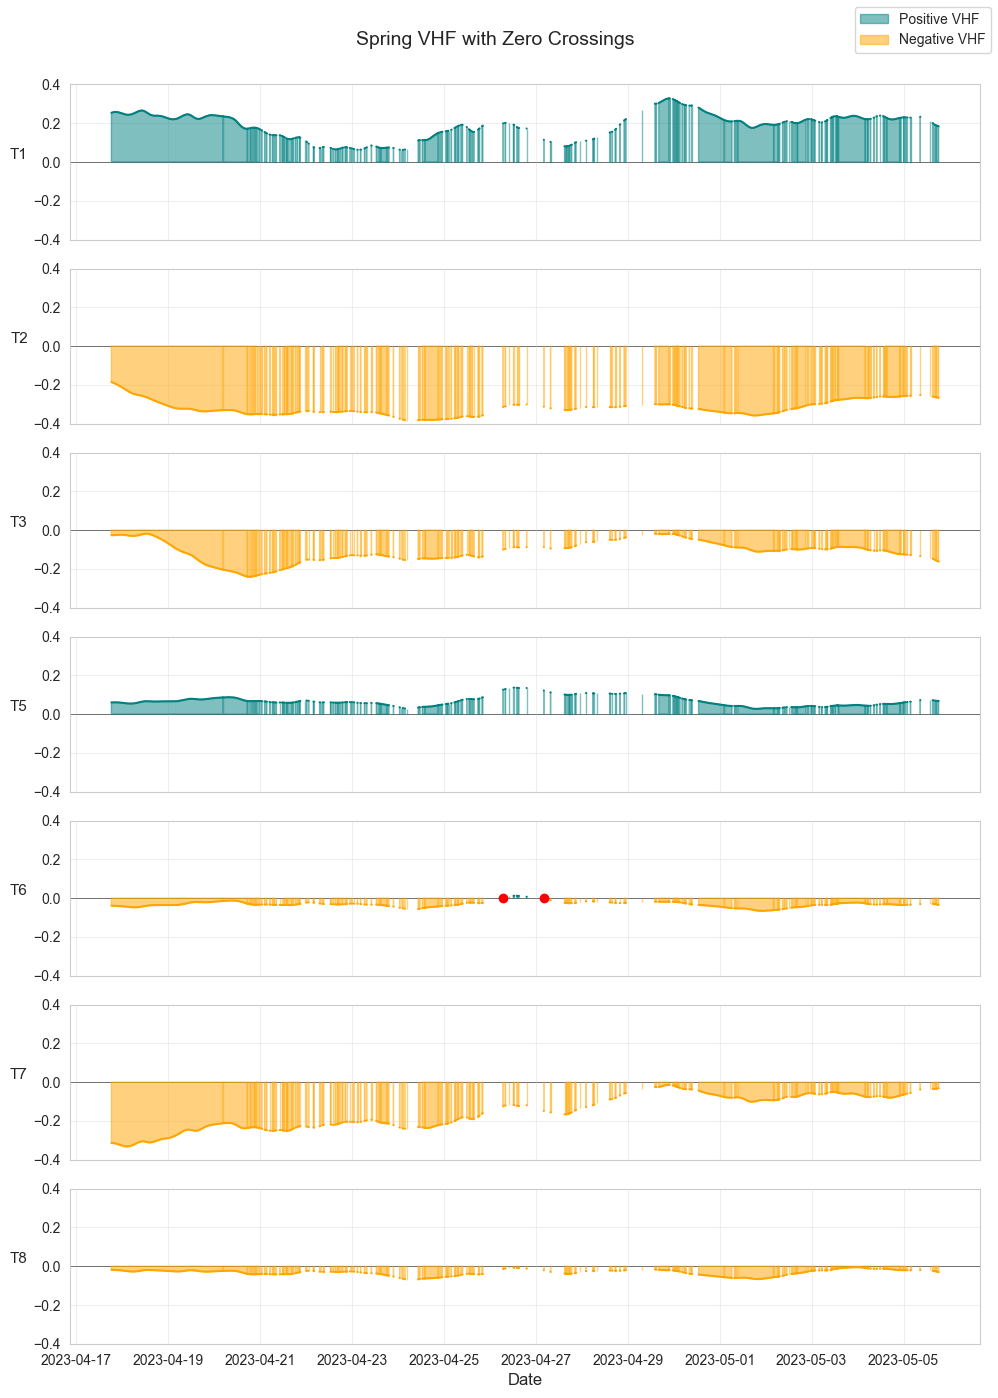

In [74]:
# settings
sns.set_style("whitegrid")
max_gap = pd.Timedelta("5min")  # define data gap
probes = ["T1", "T2", "T3", "T5", "T6", "T7", "T8"]
positive_color = "teal"
negative_color = 'orange'

# figure
fig, axes = plt.subplots(len(probes), 1, figsize=(10, 2 * len(probes)), sharex=True)
# loop through probes
for ax, probe in zip(axes, probes):

    # get data
    s = exceedance_spring[probe].dropna().sort_index()
    if s.empty:
        continue

    # insert NaNs at gaps to break line plotting
    dt = s.index.to_series().diff()
    s_plot = s.copy()
    s_plot[dt > max_gap] = np.nan

    # zero crossings (gap-bridged)
    s_zc = s[s != 0]
    signs = np.sign(s_zc.values)
    crossings = signs[:-1] * signs[1:] < 0
    crossing_indices = np.where(crossings)[0] + 1

    # plot time series (no connections across gaps)
    ax.plot(s_plot.index, s_plot.where(s_plot > 0).values, color=positive_color, linewidth=1.5, zorder=2)
    ax.plot(s_plot.index, s_plot.where(s_plot < 0).values, color=negative_color, linewidth=1.5, zorder=2)
    # fill areas under curve
    ax.fill_between(s_plot.index, 0, s_plot.values, where=(s_plot.values > 0), interpolate=True, color=positive_color, alpha=0.5, zorder=1) # positive
    ax.fill_between(s_plot.index, 0, s_plot.values, where=(s_plot.values < 0), interpolate=True, color=negative_color, alpha=0.5, zorder=1) # negative

    # mark zero crossings
    for idx in crossing_indices:
        if idx < len(s_zc):
            ax.plot(s_zc.index[idx], 0, 'o', color='red', markersize=6, zorder=3)

    # formatting
    ax.axhline(0, color='k', linewidth=0.5, zorder=0)
    ax.set_ylabel(probe, rotation=0, labelpad=10, fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.4, 0.4)

# labels and legend
axes[-1].set_xlabel('Date', fontsize=12)
positive_patch = mpatches.Patch(color=positive_color, alpha=0.5, label='Positive VHF')
negative_patch = mpatches.Patch(color=negative_color, alpha=0.5, label='Negative VHF')

fig.legend(handles=[positive_patch, negative_patch], loc='upper right', fontsize=10)
fig.suptitle('Spring VHF with Zero Crossings', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig("plots/spring_exceedance_hf_zero_crossings.png", dpi=300)
plt.show()


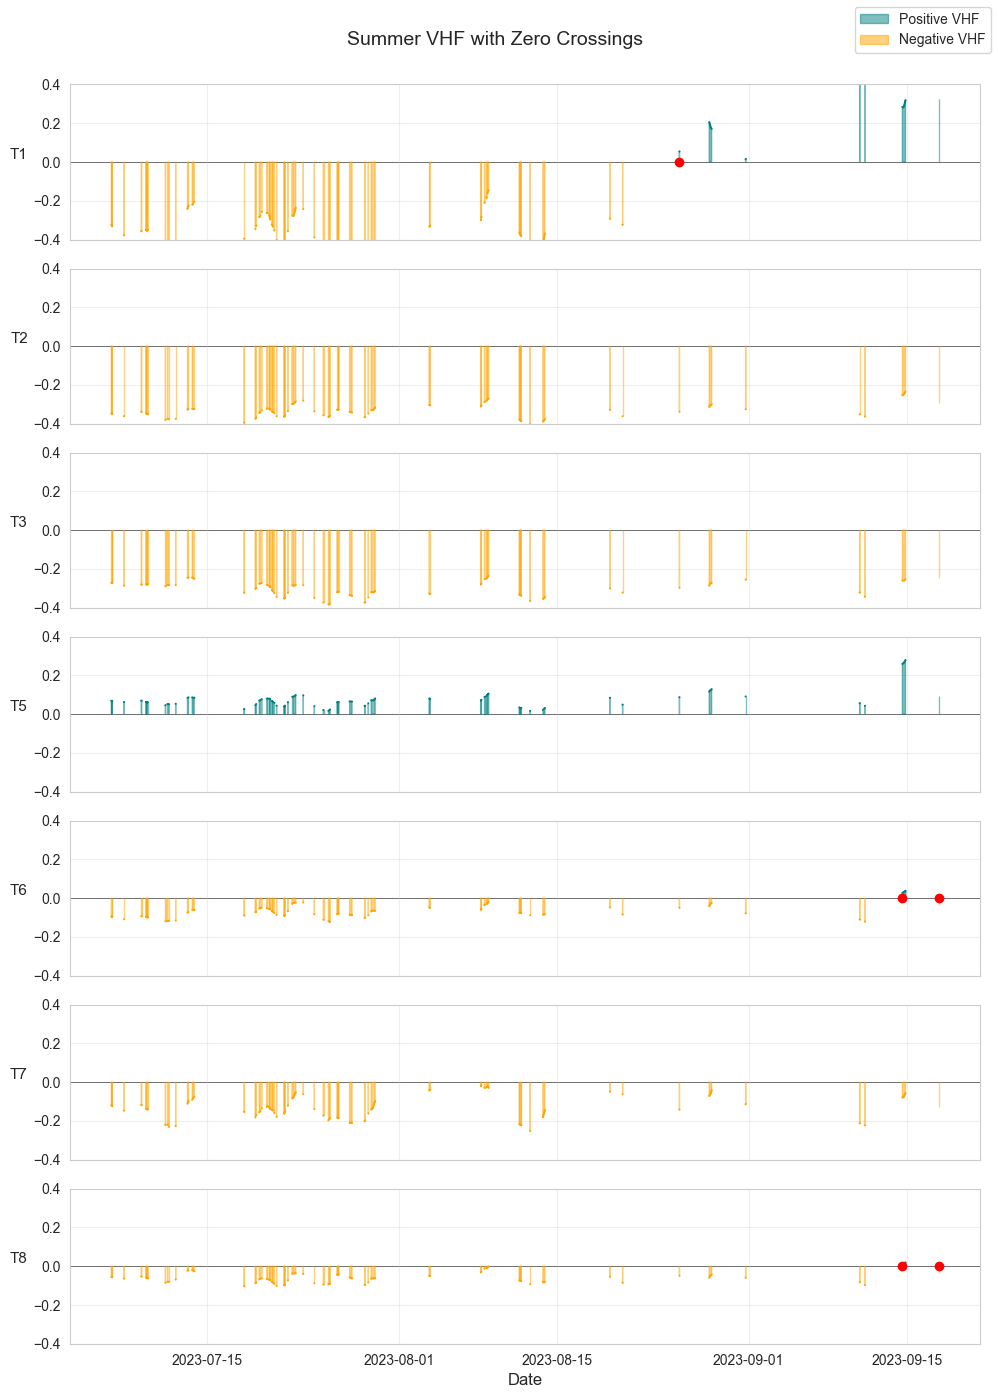

In [92]:
# settings
sns.set_style("whitegrid")
max_gap = pd.Timedelta("20min")  # define data gap
probes = ["T1", "T2", "T3", "T5", "T6", "T7", "T8"]
positive_color = "teal"
negative_color = "orange"

# figure
fig, axes = plt.subplots(len(probes), 1, figsize=(10, 2 * len(probes)), sharex=True)
# loop through probes
for ax, probe in zip(axes, probes):

    # get data
    s = exceedance_summer[probe].dropna().sort_index()
    if s.empty:
        continue

    # insert NaNs at gaps to break line plotting
    dt = s.index.to_series().diff()
    s_plot = s.copy()
    s_plot[dt > max_gap] = np.nan

    # zero crossings (gap-bridged)
    s_zc = s[s != 0]
    signs = np.sign(s_zc.values)
    crossings = signs[:-1] * signs[1:] < 0
    crossing_indices = np.where(crossings)[0] + 1

    # plot time series (no connections across gaps)
    ax.plot(s_plot.index, s_plot.where(s_plot > 0).values, color=positive_color, linewidth=1.5, zorder=2)
    ax.plot(s_plot.index, s_plot.where(s_plot < 0).values, color=negative_color, linewidth=1.5, zorder=2)
    # fill areas under curve
    ax.fill_between(s_plot.index, 0, s_plot.values, where=(s_plot.values > 0), interpolate=True, color=positive_color, alpha=0.5, zorder=1) # positive
    ax.fill_between(s_plot.index, 0, s_plot.values, where=(s_plot.values < 0), interpolate=True, color=negative_color, alpha=0.5, zorder=1) # negative

    # mark zero crossings
    for idx in crossing_indices:
        if idx < len(s_zc):
            ax.plot(s_zc.index[idx], 0, 'o', color='red', markersize=6, zorder=3)

    # formatting
    ax.axhline(0, color='k', linewidth=0.5, zorder=0)
    ax.set_ylabel(probe, rotation=0, labelpad=10, fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.4, 0.4)

# labels and legend
axes[-1].set_xlabel('Date', fontsize=12)
positive_patch = mpatches.Patch(color=positive_color, alpha=0.5, label='Positive VHF')
negative_patch = mpatches.Patch(color=negative_color, alpha=0.5, label='Negative VHF')

fig.legend(handles=[positive_patch, negative_patch], loc='upper right', fontsize=10)
fig.suptitle('Summer VHF with Zero Crossings', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig("plots/summer_exceedance_hf_zero_crossings.png", dpi=300)
plt.show()